In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError
import joblib

In [6]:
# Cargar los datos de generación y meteorológicos
plant_1_generation = pd.read_csv('Plant_1_Generation_Data.csv')
plant_1_weather = pd.read_csv('Plant_1_Weather_Sensor_Data.csv')

# Copiar los datos de generación para mantener df_GD1 limpio
df_GD1 = plant_1_generation.copy()

# Aplicar el mapeo a los nombres de los paneles solares
unique_source_keys_list = df_GD1['SOURCE_KEY'].unique()
source_key_mapping = {key: f"Solar_Panel_{i+1}" for i, key in enumerate(unique_source_keys_list)}
df_GD1['SOURCE_KEY'] = df_GD1['SOURCE_KEY'].map(source_key_mapping)

# Convertir la columna 'DATE_TIME' a formato de fecha y hora
df_GD1['DATE_TIME'] = pd.to_datetime(df_GD1['DATE_TIME'], format='%d-%m-%Y %H:%M')
plant_1_weather['DATE_TIME'] = pd.to_datetime(plant_1_weather['DATE_TIME'], format='%Y-%m-%d %H:%M:%S')

# Unir los datos meteorológicos al dataframe de generación en función de la fecha y hora
df_GD1_with_weather = pd.merge(df_GD1, plant_1_weather, on='DATE_TIME', how='left')

# Eliminar las columnas PLANT_ID_y y SOURCE_KEY_y y renombrar las columnas PLANT_ID_x y SOURCE_KEY_x
df_GD1_with_weather_clean = df_GD1_with_weather.drop(columns=['PLANT_ID_y', 'SOURCE_KEY_y','PLANT_ID_x'])

# Renombrar las columnas para eliminar el sufijo '_x'
df_GD1_with_weather_clean = df_GD1_with_weather_clean.rename(columns={'SOURCE_KEY_x': 'SOURCE_KEY'})

nulos = df_GD1_with_weather_clean.isnull().sum()

# Mostrar cuántos valores nulos hay por columna
print(nulos)

# Rellenar los valores nulos en solo las columnas numéricas con la media
numerical_cols = df_GD1_with_weather_clean.select_dtypes(include=['float64', 'int64']).columns #Estp para quitar los floats
df_GD1_with_weather_clean[numerical_cols] = df_GD1_with_weather_clean[numerical_cols].fillna(df_GD1_with_weather_clean[numerical_cols].mean())

df_GD1_limpio = df_GD1_with_weather_clean


DATE_TIME              0
SOURCE_KEY             0
DC_POWER               0
AC_POWER               0
DAILY_YIELD            0
TOTAL_YIELD            0
AMBIENT_TEMPERATURE    4
MODULE_TEMPERATURE     4
IRRADIATION            4
dtype: int64


___

In [7]:
variables = ['AC_POWER', 'DAILY_YIELD', 'TOTAL_YIELD','AMBIENT_TEMPERATURE', 
            'MODULE_TEMPERATURE', 'IRRADIATION']
# Definir X (variables predictoras) y Y (variable objetivo)
X_ker = df_GD1_limpio[variables].values
Y_ker = df_GD1_limpio['DC_POWER'].values

kf = KFold(n_splits=5, shuffle=True, random_state=42)
mse_scores = []
mae_scores = []
r2_scores = []

for train_index, test_index in kf.split(X_ker):
    X_train_ker, X_test_ker = X_ker[train_index], X_ker[test_index]
    Y_train_ker, Y_test_ker = Y_ker[train_index], Y_ker[test_index]
    
    scaler_ker = MinMaxScaler()
    X_train_ker = scaler_ker.fit_transform(X_train_ker)
    X_test_ker = scaler_ker.transform(X_test_ker)
    joblib.dump(scaler_ker, 'scaler_ker1.pkl')
    
    
    model = Sequential()
    model.add(Dense(128, activation='relu', input_shape=(X_train_ker.shape[1],), kernel_regularizer=l2(0.05)))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.05)))
    model.add(Dropout(0.3))
    model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.05)))
    model.add(Dense(1))
    
    model.compile(optimizer='adam', loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])
    
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    history = model.fit(X_train_ker, Y_train_ker, epochs=100, batch_size=32, verbose=0,validation_data=(X_test_ker, Y_test_ker), callbacks=[early_stop])
    
    mse, mae = model.evaluate(X_test_ker, Y_test_ker, verbose=0)
    mse_scores.append(mse)
    mae_scores.append(mae)
    
    Y_test_pred = model.predict(X_test_ker, verbose=0)
    r2 = r2_score(Y_test_ker, Y_test_pred)
    r2_scores.append(r2)
  

print("MSE en cada fold:", mse_scores)
print("MSE promedio en validación cruzada:", np.mean(mse_scores))
print("MAE en cada fold:", mae_scores)
print("MAE promedio en validación cruzada:", np.mean(mae_scores))
print("R² en cada fold:", r2_scores)
print("R² promedio en validación cruzada:", np.mean(r2_scores))


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwa

MSE en cada fold: [2797.938232421875, 1005.4627075195312, 3368.31689453125, 9493.078125, 6960.7392578125]
MSE promedio en validación cruzada: 4725.107043457031
MAE en cada fold: [29.500349044799805, 13.779687881469727, 32.92088317871094, 47.244102478027344, 50.245750427246094]
MAE promedio en validación cruzada: 34.738154602050784
R² en cada fold: [0.9998396445243795, 0.9999563524090506, 0.9998062937914848, 0.9994251912710166, 0.9995894703478228]
R² promedio en validación cruzada: 0.9997233904687508


## Con l2 = 0.1:

    MSE en cada fold: [1420.6094970703125, 17751.806640625, 2558.791015625, 2150.099853515625, 1374.83203125]
    
    MSE promedio en validación cruzada: 5051.227807617188

## Con l2 = 0.07

    MSE en cada fold: [5646.09716796875, 4039.80078125, 7870.93212890625, 928.1033325195312, 2090.483642578125]
    
    MSE promedio en validación cruzada: 4115.083410644531

## Con l2 = 0.05 (100 Epeochs):

    MSE en cada fold: [7293.02001953125, 9130.76953125, 3934.10400390625, 1131.9715576171875, 1545.7596435546875]
    
    MSE promedio en validación cruzada: 4607.124951171875

    MAE en cada fold: [51.31016540527344, 55.83679962158203, 37.021244049072266, 17.8803768157959, 25.742450714111328]

    MAE promedio en validación cruzada: 37.55820732116699

    R² en cada fold: [0.9995566448122056, 0.9994469759811657, 0.9997728926216876, 0.9999444403767382, 0.9999184111978466]
    
    R² promedio en validación cruzada: 0.9997278729979289

## Con l2 = 0.01

    MSE en cada fold: [2140.7490234375, 1137.970458984375, 2612.32470703125, 700.9194946289062, 18429.52734375]
    
    MSE promedio en validación cruzada: 5004.298205566406

___

In [8]:
model.save('Modelo_SP1.h5')

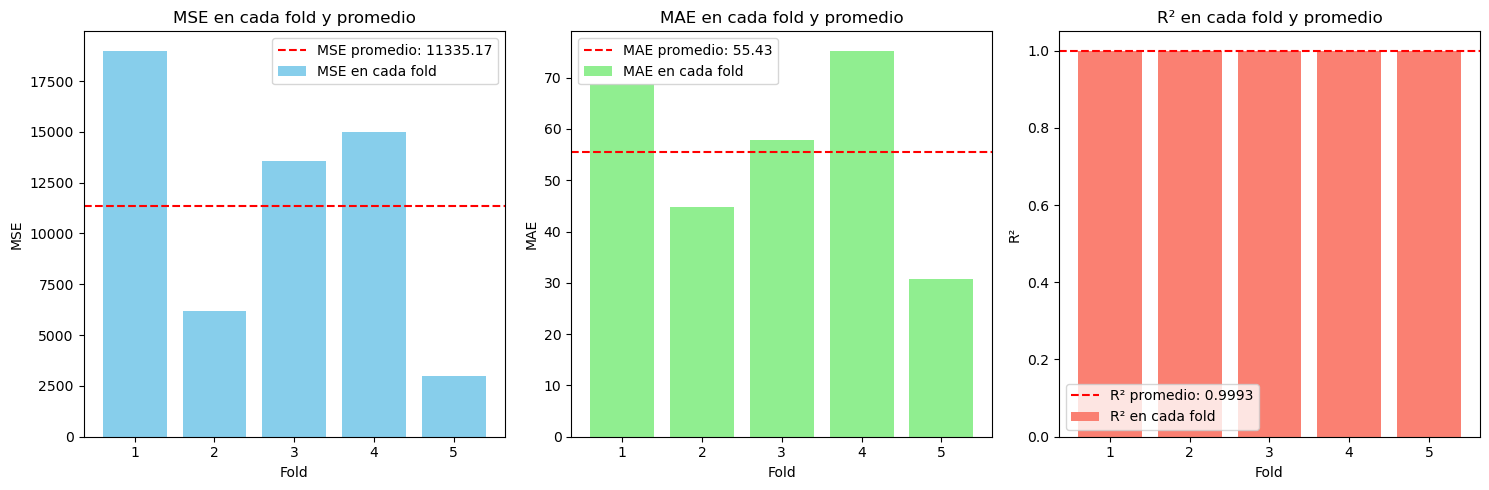

In [ ]:
# Resultados obtenidos
mse_scores = [18997.38671875, 6175.423828125, 13557.0185546875, 14970.0078125, 2976.026123046875]
mae_scores = [68.67420959472656, 44.70210266113281, 57.80636978149414, 75.27143096923828, 30.6759090423584]
r2_scores = [0.9988318065891262, 0.9996305296207392, 0.9991799478033617, 0.9990886509926628, 0.9998333797617455]

# Promedios de las métricas
mse_mean = np.mean(mse_scores)
mae_mean = np.mean(mae_scores)
r2_mean = np.mean(r2_scores)

# Crear una figura y varios subplots
plt.figure(figsize=(15, 5))

# Gráfico de MSE
plt.subplot(1, 3, 1)
plt.bar(range(1, len(mse_scores) + 1), mse_scores, color='skyblue', label="MSE en cada fold")
plt.axhline(mse_mean, color='red', linestyle='--', label=f"MSE promedio: {mse_mean:.2f}")
plt.xlabel("Fold")
plt.ylabel("MSE")
plt.title("MSE en cada fold y promedio")
plt.legend()

# Gráfico de MAE
plt.subplot(1, 3, 2)
plt.bar(range(1, len(mae_scores) + 1), mae_scores, color='lightgreen', label="MAE en cada fold")
plt.axhline(mae_mean, color='red', linestyle='--', label=f"MAE promedio: {mae_mean:.2f}")
plt.xlabel("Fold")
plt.ylabel("MAE")
plt.title("MAE en cada fold y promedio")
plt.legend()

# Gráfico de R²
plt.subplot(1, 3, 3)
plt.bar(range(1, len(r2_scores) + 1), r2_scores, color='salmon', label="R² en cada fold")
plt.axhline(r2_mean, color='red', linestyle='--', label=f"R² promedio: {r2_mean:.4f}")
plt.xlabel("Fold")
plt.ylabel("R²")
plt.title("R² en cada fold y promedio")
plt.legend()

# Mostrar los gráficos
plt.tight_layout()
plt.show()
